## Pre-processing

In [25]:
import re
import json
import nltk
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import collections as coll
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

In [2]:
# nltk.download('punkt')
st = [",", ".", "'", "!", '"', "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";", "<", "=", '>', "?",
      "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
main_characters = ['ДЖОУИ', 'МОНИКА', 'РЕЙЧЕЛ', 'РОСС', 'ФИБИ', 'ЧЕНДЛЕР']
main_characters = sorted(main_characters)
texts = {i : "" for i in main_characters}

for name in tqdm(main_characters):
    url = f'https://raw.githubusercontent.com/Alenush/style_transfer_sirius2021summer/main/data/scripts/russian/{name}.txt'
    req = requests.get(url)
    if req.status_code == requests.codes.ok:
        req = BeautifulSoup(req.text, 'html.parser')
        texts[name] = str(req)
    else:
        print('Content was not found.')

100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


## Lexical features 
#### https://github.com/ivbeg/readability.io/wiki/API

In [6]:
metrics = []
for name in tqdm(main_characters):
    text = texts[name]
    response = requests.post("http://api.plainrussian.ru/api/1.0/ru/measure/", data={"text":text})
    metrics.append((name, response.json()))
metrics = sorted(metrics, key=lambda x: x[1]['indexes']['index_SMOG'])

100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


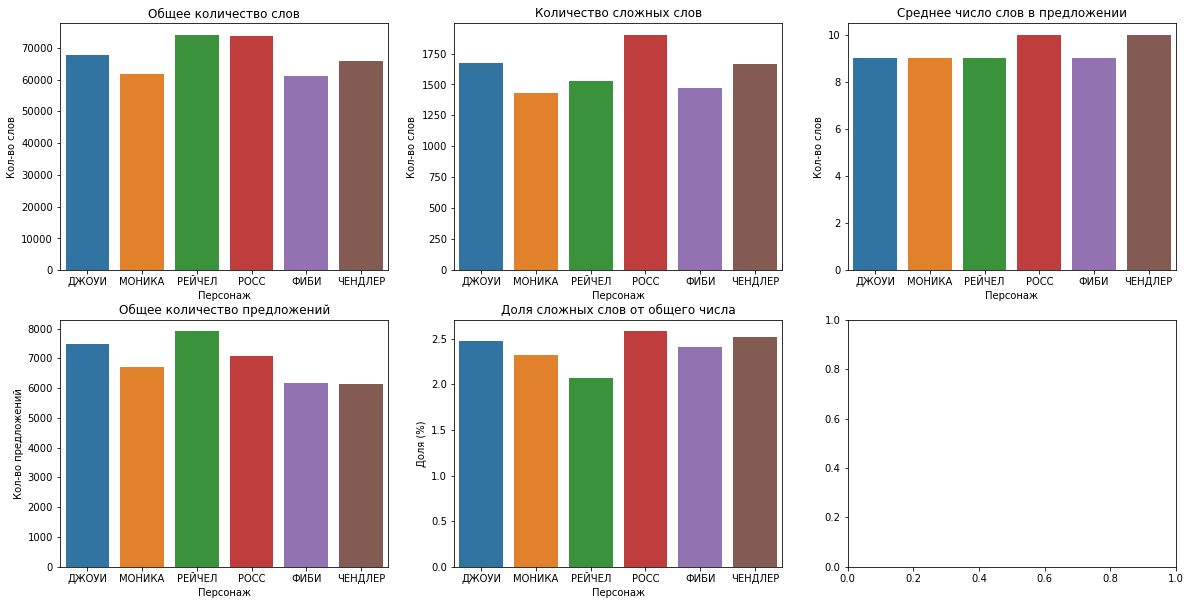

In [7]:
metrics_dct = dict(metrics)
complex_words = np.array([(name, int(metrics_dct[name]['metrics']['n_complex_words'])) for name in main_characters])
df_metrics = pd.DataFrame(complex_words)
df_metrics.columns = ['name', 'complex_words']
df_metrics.complex_words = df_metrics.complex_words.astype(int)
avg_slen  = np.array([(name, int(metrics_dct[name]['metrics']['avg_slen'])) for name in main_characters]).T[1]
df_metrics['avg_slen'] = avg_slen.astype(int)
n_words  = np.array([(name, int(metrics_dct[name]['metrics']['n_words'])) for name in main_characters]).T[1]
df_metrics['n_words'] = n_words.astype(int)
n_sentences  = np.array([(name, int(metrics_dct[name]['metrics']['n_sentences'])) for name in main_characters]).T[1]
df_metrics['n_sentences'] = n_sentences.astype(int) 
c_share  = np.array([(name, metrics_dct[name]['metrics']['c_share']) for name in main_characters]).T[1]
df_metrics['c_share'] = c_share.astype(float)


fig, axs = plt.subplots(2, 3, figsize=(20,10))
axs = axs.flatten()

ax = axs[0]
ax = sns.barplot(x="name", y="n_words", data=df_metrics, ax=ax)
ax.set(xlabel='Персонаж', ylabel='Кол-во слов', title='Общее количество слов')

ax = axs[1]
ax = sns.barplot(x="name", y="complex_words", data=df_metrics, ax=ax)
ax.set(xlabel='Персонаж', ylabel='Кол-во слов', title='Количество сложных слов')

ax = axs[2]
ax = sns.barplot(x="name", y="avg_slen", data=df_metrics, ax=ax)
ax.set(xlabel='Персонаж', ylabel='Кол-во слов', title='Среднее число слов в предложении')

ax = axs[3]
ax = sns.barplot(x="name", y="n_sentences", data=df_metrics, ax=ax)
ax.set(xlabel='Персонаж', ylabel='Кол-во предложений', title='Общее количество предложений')
 
ax = axs[4]
ax = sns.barplot(x="name", y="c_share", data=df_metrics, ax=ax)
ax.set(xlabel='Персонаж', ylabel='Доля (%)', title='Доля сложных слов от общего числа')
 
fig.patch.set_facecolor('white')
    
plt.show()

In [8]:
grades = [i for i in list(metrics_dct['РОСС']['indexes'].keys()) if i.find('grade') > -1]
for grade in grades:
    temp  = np.array([(name, metrics_dct[name]['indexes'][grade]) for name in main_characters]).T[1]
    df_metrics[grade] = temp
df_metrics

,name,complex_words,avg_slen,n_words,n_sentences,c_share,grade_SMOG,grade_ari,grade_cl,grade_fk,grade_dc
0,ДЖОУИ,1673,9,67604,7495,2.474706,4 - 6-й класс (возраст примерно: 9-11 лет),1 - 3-й класс (возраст примерно: 6-8 лет),1 - 3-й класс (возраст примерно: 6-8 лет),1 - 3-й класс (возраст примерно: 6-8 лет),4 - 6-й класс (возраст примерно: 9-11 лет)
1,МОНИКА,1434,9,61838,6718,2.318962,4 - 6-й класс (возраст примерно: 9-11 лет),1 - 3-й класс (возраст примерно: 6-8 лет),1 - 3-й класс (возраст примерно: 6-8 лет),1 - 3-й класс (возраст примерно: 6-8 лет),4 - 6-й класс (возраст примерно: 9-11 лет)
2,РЕЙЧЕЛ,1529,9,74025,7903,2.065518,4 - 6-й класс (возраст примерно: 9-11 лет),неизвестно (0),1 - 3-й класс (возраст примерно: 6-8 лет),1 - 3-й класс (возраст примерно: 6-8 лет),4 - 6-й класс (возраст примерно: 9-11 лет)
3,РОСС,1900,10,73603,7064,2.581417,4 - 6-й класс (возраст примерно: 9-11 лет),1 - 3-й класс (возраст примерно: 6-8 лет),1 - 3-й класс (возраст примерно: 6-8 лет),1 - 3-й класс (возраст примерно: 6-8 лет),4 - 6-й класс (возраст примерно: 9-11 лет)
4,ФИБИ,1472,9,61074,6173,2.410191,4 - 6-й класс (возраст примерно: 9-11 лет),1 - 3-й класс (возраст примерно: 6-8 лет),1 - 3-й класс (возраст примерно: 6-8 лет),1 - 3-й класс (возраст примерно: 6-8 лет),4 - 6-й класс (возраст примерно: 9-11 лет)
5,ЧЕНДЛЕР,1662,10,65875,6124,2.522960,4 - 6-й класс (возраст примерно: 9-11 лет),1 - 3-й класс (возраст примерно: 6-8 лет),1 - 3-й класс (возраст примерно: 6-8 лет),1 - 3-й класс (возраст примерно: 6-8 лет),4 - 6-й класс (возраст примерно: 9-11 лет)


## Vocabulary metrics
#### https://github.com/Hassaan-Elahi/Writing-Styles-Classification-Using-Stylometric-Analysis/blob/master/Code/main.py

In [9]:
def hapaxLegemena(words):
    ### only one instance of use
    
    V1 = 0
    # dictionary comprehension . har word kay against value 0 kardi
    freqs = {key: 0 for key in words}
    for word in words:
        freqs[word] += 1
    for word in freqs:
        if freqs[word] == 1:
            V1 += 1
    N = len(words)
    V = float(len(set(words)))
    R = 100 * math.log(N) / max(1, (1 - (V1 / V)))
    h = V1 / N
    return h

def ShannonEntropy(words):
    # -1*sigma(pi*lnpi)
    # Shannon and sympsons index are basically diversity indices for any community
    
    lenght = len(words)
    freqs = coll.Counter()
    freqs.update(words)
    arr = np.array(list(freqs.values()))
    distribution = 1. * arr
    distribution /= max(1, lenght)
    import scipy as sc
    H = sc.stats.entropy(distribution, base=2)
    # H = sum([(i/lenght)*math.log(i/lenght,math.e) for i in freqs.values()])
    return H

def YulesCharacteristicK(words):
    # K  10,000 * (M - N) / N**2
    # , where M  Sigma i**2 * Vi.
    N = len(words)
    freqs = coll.Counter()
    freqs.update(words)
    vi = coll.Counter()
    vi.update(freqs.values())
    M = sum([(value * value) * vi[value] for key, value in freqs.items()])
    K = 10000 * (M - N) / math.pow(N, 2)
    return K

In [10]:
%%time
voc_metrics = []
for name in main_characters:
    text = nltk.tokenize.word_tokenize(texts[name])
    words = [word for word in text if word not in st]
    
    voc_metrics_name = [name]
    voc_metrics_name.append(hapaxLegemena(words))
    voc_metrics_name.append(ShannonEntropy(words))
    voc_metrics_name.append(YulesCharacteristicK(words))
    voc_metrics.append(voc_metrics_name)
df_voc_metrics = pd.DataFrame(voc_metrics)
df_voc_metrics.columns = ['name', 'hapaxLegemena', 'ShannonEntropy', 'Yules']
df_voc_metrics

<ipython-input-9-730e812bb635>:42: RuntimeWarning: overflow encountered in long_scalars
  K = 10000 * (M - N) / math.pow(N, 2)


Wall time: 12.6 s


,name,hapaxLegemena,ShannonEntropy,Yules
0,ДЖОУИ,0.093630,10.267860,0.234410
1,МОНИКА,0.099316,10.250583,-0.265612
2,РЕЙЧЕЛ,0.081167,9.981475,-0.162628
3,РОСС,0.093496,10.266656,0.112953
4,ФИБИ,0.104229,10.243055,-0.029298
5,ЧЕНДЛЕР,0.103796,10.328184,-0.296172


## Readability metrics
#### https://github.com/Hassaan-Elahi/Writing-Styles-Classification-Using-Stylometric-Analysis/blob/master/Code/main.py

##### Upd: расчет Readability index по ссылке не подходит для русского 

In [11]:
# cmuDictionary = None

# def syllable_count_Manual(word):
#     word = word.lower()
#     count = 0
#     vowels = "ауоыиэяюёе"
#     if word[0] in vowels:
#         count += 1
#     for index in range(1, len(word)):
#         if word[index] in vowels and word[index - 1] not in vowels:
#             count += 1
#             if word.endswith("e"):
#                 count -= 1
#     if count == 0:
#         count += 1
#     return count

# def syllable_count(word):
#     global cmuDictionary
#     d = cmuDictionary
#     try:
#         syl = [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]][0]
#     except:
#         syl = syllable_count_Manual(word)
#     return syl

# def FleschReadingEase(words, NoOfsentences):
#     l = float(len(words))
#     scount = 0
#     for word in words:
#         scount += syllable_count(word)

#     I = 206.835 - 1.015 * (l / float(NoOfsentences)) - 84.6 * (scount / float(l))
#     return I

# # def dale_chall_readability_formula(words, NoOfSectences):
# #     difficult = 0
# #     adjusted = 0
# #     NoOfWords = len(words)
# #     with open('dale-chall.pkl', 'rb') as f:
# #         fimiliarWords = pickle.load(f)
# #     for word in words:
# #         if word not in fimiliarWords:
# #             difficult += 1
# #     percent = (difficult / NoOfWords) * 100
# #     if (percent > 5):
# #         adjusted = 3.6365
# #     D = 0.1579 * (percent) + 0.0496 * (NoOfWords / NoOfSectences) + adjusted
# #     return D

# def GunningFoxIndex(words, NoOfSentences):
#     NoOFWords = float(len(words))
#     complexWords = 0
#     for word in words:
#         if (syllable_count(word) > 2):
#             complexWords += 1

#     G = 0.4 * ((NoOFWords / NoOfSentences) + 100 * (complexWords / NoOFWords))
#     return G

# # winSize = 10
# # voc_metrics = []
# # for name in main_characters:
# #     text = nltk.tokenize.word_tokenize(texts[name])
# #     words = [word for word in text if word not in st]
    
# #     voc_metrics_name = [name]
# #     voc_metrics_name.append(FleschReadingEase(words, winSize))
# # #     voc_metrics_name.append(dale_chall_readability_formula(words, winSize))
# #     voc_metrics_name.append(GunningFoxIndex(words, winSize))
# #     voc_metrics.append(voc_metrics_name)
# # df_voc_metrics = pd.DataFrame(voc_metrics)
# # df_voc_metrics.columns = ['name', 'Flesch', 'GunFox']
# # df_voc_metrics

## Sentiment analysis
#### https://github.com/cyberdh/Text-Analysis/tree/master/VADERSentimentAnalysis
##### Смотрим соотношение положительной/ негативной лексики у персонажей.
##### NB: используем скрипты на английском

In [12]:
posWords = pd.read_csv("posWords.csv", index_col=False).iloc[:, 1:]
pos_list = posWords.values.T[0] 
negWords = pd.read_csv("negWords.csv", index_col=False).iloc[:, 1:]
neg_list = negWords.values.T[0] 

In [13]:
en_text = {name : [] for name in main_characters}
en_text['НЕДРУГ'] = []

for i in tqdm(range(1, 11)):
    url = f'https://github.com/Alenush/style_transfer_sirius2021summer/tree/master/data/scripts/english/{i}'
    req = requests.get(url)
    soup = BeautifulSoup(req.content, 'html.parser')
    for j in soup.find_all('span', {"class": "css-truncate css-truncate-target d-block width-fit"}):
        url = f'https://raw.githubusercontent.com' + j.find('a')['href'].replace('blob/', '') 
        req = requests.get(url)
        if req.status_code == requests.codes.ok:
            soup = str(BeautifulSoup(req.text, 'html.parser'))
        else:
            print('Content was not found.')
        script = []
        for line in soup.split('\n'):
            if len(line) != 0 and line[0].isupper():
                tag = line.find(":")
                script.append((line[:tag], line[tag + 1:].strip()))
        for person in set([i[0] for i in script]):
            words = [i[1] for i in script if i[0] == person]
            en_text[person] += words

100%|██████████| 10/10 [02:33<00:00, 15.36s/it]


In [14]:
ch = sorted(list(set([i[0] for i in script])))
en_bags = en_text.copy()
for person in ch:
    # person = ch[0]
    seq = "\n".join(en_text[person])
    seq = re.sub("<(.*?)>", "", seq)
    for i in st:
        if i == "'":
            continue
        if i in ('(', ')', '*', '+', '?', '[', '\\', '^'):
            seq = re.sub('[\\' + f'{i}]', " ", seq)
        else:
            seq = re.sub(f'[{i}]', " ", seq)
        seq = re.sub(" +", " ", seq)
    seq = seq.lower()
    seq = seq.split()

    lemmatizer = WordNetLemmatizer()
    seq_lem = [lemmatizer.lemmatize(s, pos='v') for s in seq]
    en_bags[person] = seq_lem

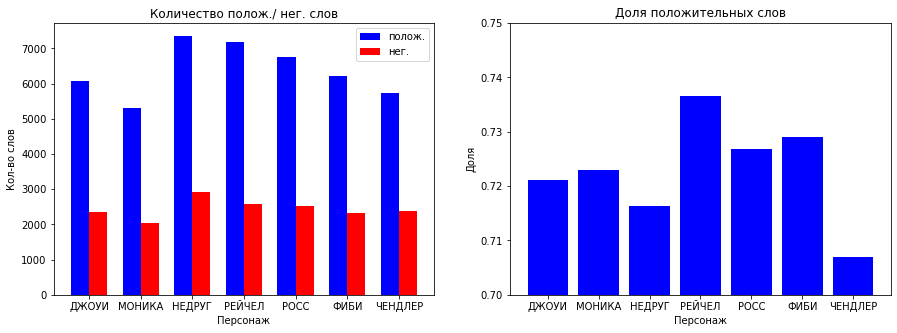

In [16]:
sentiment_res = dict()
for person in ch:
    person_bag = en_bags[person]
    person_pos = {w : person_bag.count(w) for w in pos_list}
    person_neg = {w : person_bag.count(w) for w in neg_list}
    sentiment_res[person] = (person_pos, person_neg)
    
pos = []
neg = []
for name in sentiment_res:
    pos.append(sum(list(sentiment_res[name][0].values())))
    neg.append(sum(list(sentiment_res[name][1].values())))
posneg = np.array([pos, neg])
posneg_sh = posneg[0] / (posneg[0] + posneg[1])

persons = list(sentiment_res.keys())
index = np.arange(len(persons))
bar_width = 0.35


fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs = axs.flatten()

ax = axs[0]
pos_plot = ax.bar(index, pos, bar_width, label='полож.', color='b')
neg_plot = ax.bar(index+bar_width, neg, bar_width, label='нег.', color='r')
ax.set_xlabel('Персонаж')
ax.set_ylabel('Кол-во слов')
ax.set_title('Количество полож./ нег. слов')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(persons)
ax.legend()

ax = axs[1]
# ax.bar(persons, (posneg_sh*0+1), label='полож.', color='r')
ax.bar(persons, posneg_sh, label='полож.', color='b')
ax.set_xlabel('Персонаж')
ax.set_ylabel('Доля')
ax.set_title('Доля положительных слов')
ax.set(ylim=(0.7, 0.75))

fig.patch.set_facecolor('white')

plt.show()

## Биграммы

In [31]:
# def delete_rep(text):
#     text = re.sub(' +', ' ', text)
#     text = re.sub('(эй )+', 'эй ', text)
#     text = re.sub('(э )+', 'э ', text)
#     text = re.sub('(ха )+', 'ха ', text)
#     text = re.sub('(размытие )+', 'размытие ', text)
#     text = re.sub('(ох )+', 'ох ', text)
#     text = re.sub('(хо )+', 'хо ', text)
#     text = re.sub('(ой )+', 'ой ', text)
#     text = re.sub('(подожди )+', 'подожди ', text)
#     text = re.sub('(подождите )+', 'подождите ', text)
#     text = re.sub('(ладно )+', 'ладно ', text)
#     text = re.sub('(ла )+', 'ла ', text)
#     text = re.sub('(смотри )+', 'смотри ', text)
#     text = re.sub('(смотрите )+', 'смотрите ', text)
#     text = re.sub('(ву )+', 'ву ', text)
#     text = re.sub('(бла )+', 'бла ', text)
#     text = re.sub('(хур )+', 'хур ', text)
#     text = re.sub('(хорошо )+', 'хорошо ', text)
#     text = re.sub('(погоди )+', 'погоди ', text)
#     text = re.sub('(погодите )+', 'погодите ', text)
#     text = re.sub('(ага )+', 'ага ', text)
#     text = re.sub('(давай )+', 'давай ', text)
#     text = re.sub('(хорошая игра )+', 'хорошая игра ', text)
#     text = re.sub('(вонючий кот )+', 'вонючий кот ', text)
#     text = re.sub('(7 )+', '7 ', text)
#     text = re.sub('(друг )+', 'друг ', text)
#     text = re.sub('(hey )+', 'hey ', text)
#     text = re.sub('(whoa )+', 'whoa ', text)
#     text = re.sub('(yeah )+', 'yeah ', text)
#     text = re.sub('(wait )+', 'wait ', text)
#     text = re.sub('(la )+', 'la ', text)
#     text = re.sub('(ha )+', 'ha ', text)
#     text = re.sub('(ho )+', 'ho ', text)
#     text = re.sub('(oh )+', 'oh ', text)
#     text = re.sub('(bye )+', 'bye ', text)
#     text = re.sub('(kitty )+', 'kitty ', text)
#     text = re.sub('(ow )+', 'ow ', text)
#     text = re.sub('(ooh )+', 'ooh ', text)
#     text = re.sub('(woo )+', 'woo ', text)
#     text = re.sub('(woah )+', 'woah ', text)
#     text = re.sub('(uh )+', 'uh ', text)
#     text = re.sub('(listen )+', 'listen ', text)
#     text = re.sub('(blur )+', 'blur ', text)
#     text = re.sub('(ross )+', 'ross ', text)
#     text = re.sub('(blah )+', 'blah ', text)
#     text = re.sub('(hur )+', 'hur ', text)
#     text = re.sub('(alright )+', 'alright ', text)
#     text = re.sub('(monica )+', 'monica ', text)
#     text = re.sub('(quack )+', 'quack ', text)
#     text = re.sub('(whoo )+', 'whoo ', text)
#     text = re.sub('(good game )+', 'good game ', text)
#     text = re.sub('(whoo )+', 'whoo ', text)
#     text = re.sub('(ew )+', 'ew ', text)
#     text = re.sub('(yep )+', 'yep ', text)
#     text = re.sub('(wha wh )+', 'wha wh ', text)
#     text = re.sub('(baby ooh )+', 'baby ooh ', text)
#     text = re.sub('(mon )+', 'mon ', text)
#     text = re.sub('(bing )+', 'bing ', text)
#     text = re.sub('(coke diet )+', 'coke diet ', text)
#     text = re.sub('(diet coke )+', 'diet coke ', text)
#     text = re.sub('(ooh baby baby )+', 'ooh baby baby ', text)
#     text = re.sub('(good )+', 'good ', text)
#     text = re.sub('(mee )+', 'mee ', text)
#     text = re.sub('(ar )+', 'ar ', text)
#     text = re.sub('(shoop )+', 'shoop ', text)
#     text = re.sub('(sick )+', 'sick ', text)
#     text = re.sub('(damnit )+', 'damnit ', text)
#     text = re.sub('(smelly cat )+', 'smelly cat ', text)
#     text = re.sub('(tweet )+', 'tweet', text)
#     text = re.sub('(quack )+', 'quack', text)
#     text = re.sub('(ye )+', 'ye ', text)
#     text = re.sub('(good luck )+', 'good luck ', text)
#     # text = re.sub('( )+', ' ', text)
#     return text

# with open('stop_words_english.txt') as f:
#     lines = f.readlines()
# stop_en = [el.strip() for el in lines]
# stop_en[:5]

In [32]:
# main_characters = ['ДЖОУИ', 'МОНИКА', 'РЕЙЧЕЛ', 'РОСС', 'ФИБИ', 'ЧЕНДЛЕР']
# dict_freq = dict()

# for name in tdqm(main_characters):
#     text = " ".join(en_bags[name])
#     text = text.replace(".", ' 1234').replace("!", ' 1234').replace("?", ' 1234')
#     text = re.sub(r'[^\w\s]', ' ', text).lower()#.replace('1230123', "'")
#     text = delete_rep(text)
#     text = text.split(' 1234')
#     text = [el.strip() for el in text if el != '']
#     bigrams_tmp = [b for l in text for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
#     lemmatizer = WordNetLemmatizer()
#     bigrams = [(lemmatizer.lemmatize(el[0],  pos='v'), lemmatizer.lemmatize(el[1], pos='v')) for el in bigrams_tmp]
#     bigrams = [el for el in bigrams if el[0] not in stopwords.words('english') and el[1] not in stopwords.words('english') and el[0] not in stop_en and el[1] not in stop_en and 'hey' not in el and 'uh' not in el]
#     dict_freq[name] = Counter(bigrams).most_common(50)
#     print(f"{name}.\n{Counter(bigrams).most_common(7)}")

In [33]:
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud
# fig, axs = plt.subplots(3,2, figsize=(20,15), facecolor='black')
# i = 0
# for fr in dict_freq:
#     solo_freq = dict()
#     for el in dict_freq[fr]:
#         phr = ' '.join(el[0])
#         solo_freq[phr] = el[1]
#     cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(solo_freq)
#     axs[i%3, i%2].imshow(cloud, interpolation='bilinear')
#     axs[i%3, i%2].axis('off')
#     axs[i%3, i%2].set_title(fr, color='w', fontsize=20)
#     i += 1
# fig.tight_layout(pad=1.0)
# plt.show()